# Task 3 - Example of Unit Commitment Problem
1. logging on https://colab.research.google.com/ with an google account
2. upload notebook Task3.ipynb
3. execute cells

We are using pyomo as modelling language and glpk as solver. Both are open-source.

For every optimization problem, you need
- a modelling language to formulate the model mathematically in Code
- a Solver: e.g. Pyomo itself is just a modeling tool—it doesn’t solve the problem directly. It relies on external solvers like GLPK to compute solutions for the mathematical models.

**Difference from Task 3:**
- We assume a hour t=0, where every powerplant is not running and the articficial demand is 0 to make the problem real world applicable.
- Also the demand is as follows:
  - Hour 1: 300 MW
  - Hour 2: 600 MW
  - Hour 3: 500 MW
  - Hour 4: 200 MW
  - Hour 5: 100 MW
  - Hour 6: 100 MW
  - Hour 7: 200 MW
  - Hour 8: 500 MW
  - Hour 9: 600 MW
  - Hour 10: 600 MW




In [6]:
!pip install -q pyomo  #install modelling language pyomo
!apt-get install -y -qq glpk-utils  #install open-source solver glpk

In [ ]:
from pyomo.environ import *

# Create a Pyomo model
model = ConcreteModel()

# Sets
plants = ['A', 'B']  # Power plants
hours = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9 ,10]  # Time periods

# Parameters
startup_cost = {'A': 1000, 'B': 2000}
shutdown_cost = {'A': 500, 'B': 1000}
running_cost = {'A': 30, 'B': 20}  # Cost per MW
min_output = {'A': 100, 'B': 200}
max_output = {'A': 400, 'B': 600}
ramp_rate = {'A': 100, 'B': 200}
demand = {0: 0, 1: 300, 2: 600, 3: 500, 4: 200, 5: 100, 6: 100, 7: 200, 8: 500, 9: 600, 10: 600}  # Hourly demand

# Decision Variables
model.p = Var(plants, hours, within=NonNegativeReals)  # Power generation
model.x = Var(plants, hours, within=Binary)  # Binary for running
model.start = Var(plants, hours, within=Binary)  # Binary for startup
model.shut = Var(plants, hours, within=Binary)  # Binary for shutdown

# Objective Function: Minimize total costs
def total_cost(model):
    return sum(
        startup_cost[n] * model.start[n, t] +
        shutdown_cost[n] * model.shut[n, t] +
        running_cost[n] * model.p[n, t]
        for n in plants for t in hours
    )
model.obj = Objective(rule=total_cost, sense=minimize)

# Constraints

# Demand satisfaction
def demand_constraint(model, t):
    return sum(model.p[n, t] for n in plants) == demand[t]
model.demand_con = Constraint(hours, rule=demand_constraint)

# Min and max generation
def min_max_generation(model, n, t):
    return model.x[n, t] * min_output[n] <= model.p[n, t]
model.min_gen = Constraint(plants, hours, rule=min_max_generation)

def max_generation(model, n, t):
    return model.p[n, t] <= model.x[n, t] * max_output[n]
model.max_gen = Constraint(plants, hours, rule=max_generation)

# Logical conditions for startup and shutdown (special case for first hour, because t = 0 doesn't exist)
def startup_logic(model, n, t):
    if t == 0:
        return model.start[n, t] >= model.x[n, t]
    return model.start[n, t] >= model.x[n, t] - model.x[n, t-1]
model.startup_con = Constraint(plants, hours, rule=startup_logic)

def shutdown_logic(model, n, t):
    if t == 0:
        return model.shut[n, t] >= 0
    return model.shut[n, t] >= model.x[n, t-1] - model.x[n, t]
model.shutdown_con = Constraint(plants, hours, rule=shutdown_logic)

# Ramp up rate constraints (special case for first hour, because t = 0 doesn't exist)
def ramp_rate_constraint(model, n, t):
    if t == 0:
        return Constraint.Skip
    return model.p[n, t] - model.p[n, t-1] <= ramp_rate[n]
model.ramp_con_up = Constraint(plants, hours, rule=ramp_rate_constraint)

# Ramp down rate constraints (special case for first hour, because t = 0 doesn't exist)
def ramp_rate_constraint(model, n, t):
    if t == 0:
        return Constraint.Skip
    return model.p[n, t-1] - model.p[n, t] <= ramp_rate[n]
model.ramp_con_down = Constraint(plants, hours, rule=ramp_rate_constraint)

# Solve the model
solver = SolverFactory('glpk', executable='/usr/bin/glpsol')
solver.solve(model, tee=True)


In [21]:
# Print results
print("Optimized Power Generation (MW):")
for n in plants:
    for t in hours:
        print(f"Plant {n}, Hour {t}: {model.p[n, t].value} MW")
print("\n")
print("\nStartup and Shutdown Decisions:")
for n in plants:
    for t in hours:
        print(f"Plant {n}, Hour {t}: Start={model.start[n, t].value}, Shut={model.shut[n, t].value}, Run={model.x[n, t].value}")

Optimized Power Generation (MW):
Plant A, Hour 0: 0.0 MW
Plant A, Hour 1: 100.0 MW
Plant A, Hour 2: 200.0 MW
Plant A, Hour 3: 100.0 MW
Plant A, Hour 4: 0.0 MW
Plant A, Hour 5: 100.0 MW
Plant A, Hour 6: 100.0 MW
Plant A, Hour 7: 0.0 MW
Plant A, Hour 8: 100.0 MW
Plant A, Hour 9: 0.0 MW
Plant A, Hour 10: 0.0 MW
Plant B, Hour 0: 0.0 MW
Plant B, Hour 1: 200.0 MW
Plant B, Hour 2: 400.0 MW
Plant B, Hour 3: 400.0 MW
Plant B, Hour 4: 200.0 MW
Plant B, Hour 5: 0.0 MW
Plant B, Hour 6: 0.0 MW
Plant B, Hour 7: 200.0 MW
Plant B, Hour 8: 400.0 MW
Plant B, Hour 9: 600.0 MW
Plant B, Hour 10: 600.0 MW



Startup and Shutdown Decisions:
Plant A, Hour 0: Start=0.0, Shut=0.0, Run=0.0
Plant A, Hour 1: Start=1.0, Shut=0.0, Run=1.0
Plant A, Hour 2: Start=0.0, Shut=0.0, Run=1.0
Plant A, Hour 3: Start=0.0, Shut=0.0, Run=1.0
Plant A, Hour 4: Start=0.0, Shut=1.0, Run=0.0
Plant A, Hour 5: Start=1.0, Shut=0.0, Run=1.0
Plant A, Hour 6: Start=0.0, Shut=0.0, Run=1.0
Plant A, Hour 7: Start=0.0, Shut=1.0, Run=0.0
Plant 

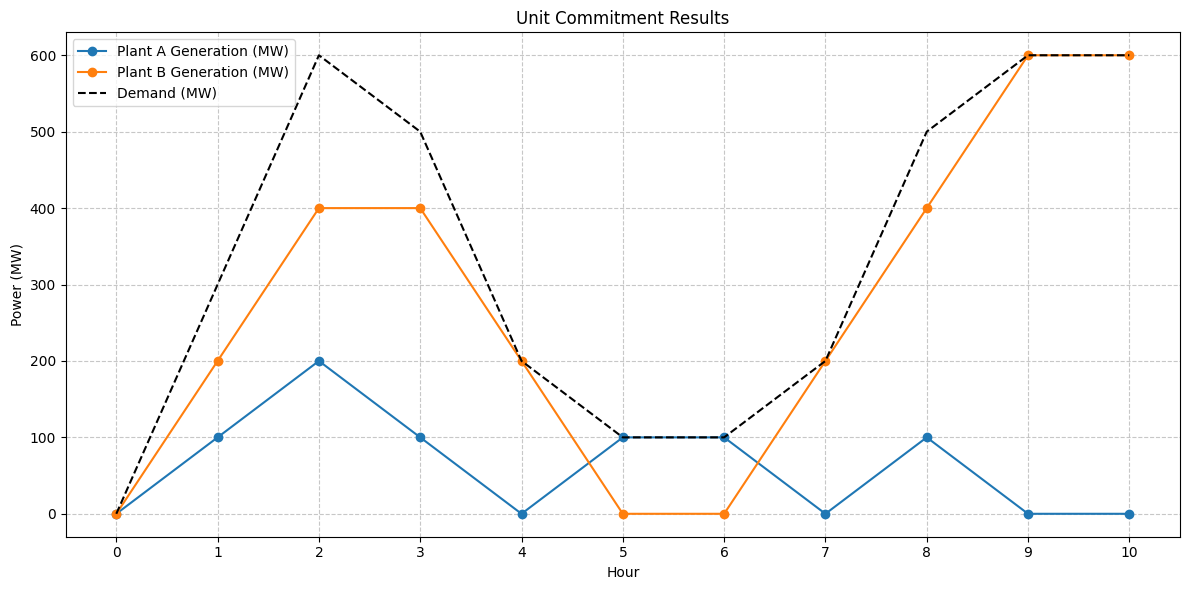

In [23]:
# Plot Results with matplotlib
import matplotlib.pyplot as plt

# Extract Results
generation = {n: [model.p[n, t].value for t in hours] for n in plants}
startups = {n: [model.start[n, t].value for t in hours] for n in plants}
shutdowns = {n: [model.shut[n, t].value for t in hours] for n in plants}

# Plotting Results
plt.figure(figsize=(12, 6))

# Power generation plot
for n in plants:
    plt.plot(hours, generation[n], label=f'Plant {n} Generation (MW)', marker='o')

# Demand line for reference
plt.plot(hours, [demand[t] for t in hours], label='Demand (MW)', linestyle='--', color='black')

# Plot settings
plt.title('Unit Commitment Results')
plt.xlabel('Hour')
plt.ylabel('Power (MW)')
plt.xticks(hours)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()